In [5]:
pip install dmba

     |████████████████████████████████| 11.8 MB 11.7 MB/s eta 0:00:01   |████████▉                       | 3.3 MB 4.0 MB/s eta 0:00:03
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline


import math
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pylab as plt

from dmba import regressionSummary, classificationSummary, liftChart, gainsChart

## 5.2 예측성능의 평가
### code for accuracy measure

In [3]:
# reduce data frame to the top 1000 rows and select columns for regression analysis
car_df = pd.read_csv('ToyotaCorolla.csv')
car_df.head(2)

Id                                          Model  Price  Age_08_04  \
0   1  TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors  13500         23   
1   2  TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors  13750         23   

   Mfg_Month  Mfg_Year     KM Fuel_Type  HP  Met_Color  ... Powered_Windows  \
0         10      2002  46986    Diesel  90          1  ...               1   
1         10      2002  72937    Diesel  90          1  ...               0   

   Power_Steering  Radio  Mistlamps  Sport_Model  Backseat_Divider  \
0               1      0          0            0                 1   
1               1      0          0            0                 1   

   Metallic_Rim  Radio_cassette  Parking_Assistant  Tow_Bar  
0             0               0                  0        0  
1             0               0                  0        0  

[2 rows x 39 columns]

In [4]:
# create a list of predictor variables by removing output variables and text coulumns
excludeColumns = ('Price', 'Id',  'Model', 'Fuel_Type', 'Color')
predictors = [s for s in car_df.columns if s not in excludeColumns]
outcome = 'Price'

In [5]:
# partition data
x = car_df[predictors]
y = car_df[outcome]
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.4, random_state = 1)

In [6]:
# train linear regression model
reg = LinearRegression()
reg.fit(train_x, train_y)

LinearRegression()

In [7]:
# evaluate performance (예측 정확성 측도들을 보여줌)
# training
regressionSummary(train_y, reg.predict(train_x))
# validation
regressionSummary(valid_y, reg.predict(valid_x))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1121.0606
            Mean Absolute Error (MAE) : 811.6770
          Mean Percentage Error (MPE) : -0.8630
Mean Absolute Percentage Error (MAPE) : 8.0054

Regression statistics

                      Mean Error (ME) : 97.1891
       Root Mean Squared Error (RMSE) : 1382.0352
            Mean Absolute Error (MAE) : 880.1396
          Mean Percentage Error (MPE) : 0.0138
Mean Absolute Percentage Error (MAPE) : 8.8744


### code for creating Figure 5.1

In [8]:
pred_error_train = pd.DataFrame({ 'residual' : train_y - reg.predict(train_x),
                                  'data set' : 'training'})
pred_error_valid = pd.DataFrame({ 'residual' : valid_y - reg.predict(valid_x),
                                  'data set' : 'validation'})
boxdata_df = pred_error_train.append(pred_error_valid, ignore_index = True)
boxdata_df.tail()

residual    data set
1431  1789.218032  validation
1432  -551.272524  validation
1433  1050.051714  validation
1434    53.907218  validation
1435 -1048.185935  validation

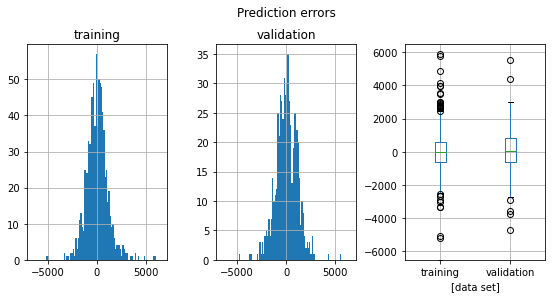

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(9,4)
common = {'bins':100, 'range':[-6500, 6500]}
pred_error_train.hist(ax=axes[0], **common)
pred_error_valid.hist(ax=axes[1], **common)
boxdata_df.boxplot(ax=axes[2], by='data set')

axes[0].set_title('training')
axes[1].set_title('validation')
axes[2].set_title('')
axes[2].set_ylim(-6500, 6500)

plt.suptitle('Prediction errors')
plt.subplots_adjust(bottom=0.1, top=0.85, wspace=0.35)
plt.show()

### code for generating cumulative gains and decline lift chart in Figure 5.2

In [10]:
pred_v = pd.Series(reg.predict(valid_x)) # 아까 만든 회귀분석모델 계속 이용
pred_v = pred_v.sort_values(ascending=False) # 예측값이 높은 것부터 내림차순으로 정렬
pred_v

34     26916.095816
174    23740.895466
519    22166.103042
569    21855.869942
252    21782.133511
           ...     
518     5282.235373
336     5151.788800
268     4954.704555
59      3600.518386
28     -1033.225248
Length: 575, dtype: float64

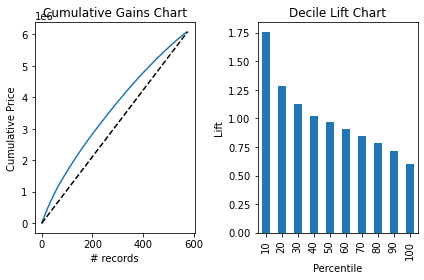

In [13]:
fig, axes = plt.subplots(nrows = 1, ncols = 2)
ax = gainsChart(pred_v, ax=axes[0]) # Cumulative chart 그리는 함수 : gainsChart (?)
ax.set_ylabel('Cumulative Price')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(pred_v, ax=axes[1], labelBars = False) # 10분위 상향차트 그리는 함수 : liftChart (?)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()

### Table 5.5 Confusion matrices based on cutoffs of 0.5, 0.25 and 0.75 (riding mowers example)

In [16]:
owner_df = pd.read_csv('ownerExample.csv')
owner_df.head()

Class  Probability
0  owner       0.9959
1  owner       0.9875
2  owner       0.9844
3  owner       0.9804
4  owner       0.9481

In [17]:
## cutoff = 0.5

predicted = ['owner' if p>0.5 else 'nonowner' for p in owner_df.Probability]

In [18]:
classificationSummary(owner_df.Class, predicted, class_names = ['nonowner', 'owner'])
# Confusion Matrix 생성 함수 : classificationSummary(진짜, 예측한거, 클래스 이름)

Confusion Matrix (Accuracy 0.8750)

         Prediction
  Actual nonowner    owner
nonowner       10        2
   owner        1       11


In [11]:
## cutoff = 0.25

predicted = ['owner' if p>0.25 else 'nonowner' for p in owner_df.Probability]
classificationSummary(owner_df.Class, predicted, class_names = ['nonowner','owner'])

Confusion Matrix (Accuracy 0.7917)

         Prediction
  Actual nonowner    owner
nonowner        8        4
   owner        1       11


In [20]:
## cutoff = 0.75

predicted = ['owner' if p>0.75 else 'nonowner' for p in owner_df.Probability]
classificationSummary(owner_df.Class, predicted, class_names = ['nonowner','owner'])

Confusion Matrix (Accuracy 0.7500)

         Prediction
  Actual nonowner    owner
nonowner       11        1
   owner        5        7


### code for creating Figure 5.4

In [21]:
df = pd.read_csv('liftexample.csv')
df.head()

prob  actual  Unnamed: 2  Unnamed: 3 Unnamed: 4
0  0.995       1         NaN         NaN        NaN
1  0.998       1         NaN         NaN        NaN
2  0.985       1         NaN         NaN        NaN
3  0.980       1         NaN         NaN        NaN
4  0.948       1         NaN         NaN        NaN

In [25]:
cutoffs = [i*0.1 for i in range(0,11)]
accT = []
for cutoff in cutoffs:
    predicted = [1 if p>cutoff else 0 for p in df.prob]
    accT.append(accuracy_score(df.actual, predicted)) # accuracy_score : accuracy 값을 내놓는 함수

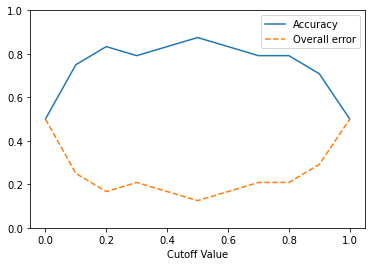

In [34]:
line_accuracy = plt.plot(cutoffs, accT, '-', label='Accuracy')[0] # 이것도 axes의 [0]번째에 그리고
line_error = plt.plot(cutoffs, [1 - acc for acc in accT], '--', label='Overall error')[0] # 이것도 [0]번째에 그린다 (아마?)
# err = 1 - accuracy
plt.ylim([0,1])
plt.xlabel('Cutoff Value')
plt.legend(handles = [line_accuracy, line_error])
plt.show()

### code for generating ROC curve and computing AUC

In [37]:
# compute ROC curve and AUC
fpr, tpr, _ = roc_curve(df.actual, df.prob)
roc_auc = auc(fpr, tpr)

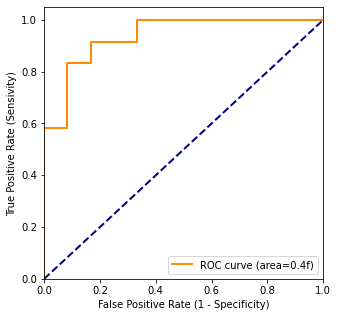

In [43]:
plt.figure(figsize=[5,5])
plt.plot(fpr, tpr, color = 'darkorange',
         lw=2, label='ROC curve (area=0.4f)' % roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)') # 1-특이도 / 특이도 : 중요하지 않은 클래스를 올바르게 제거하는 능력
plt.ylabel('True Positive Rate (Sensivity)') # 민감도 : 중요한 클래스를 올바르게 검사하는 능력 
plt.legend(loc='lower right')
plt.show()

참고 : https://pyopyo03.tistory.com/8

ROC커브의 밑면적(the Area Under a ROC Curve; AUC; AUROC) 
- ROC 커브의 X,Y축은 [0,1]의 범위며, (0,0) 에서 (1,1)을 잇는 곡선 

- ROC 커브의 밑 면적이 1에 가까울수록(즉, 왼쪽 상단 꼭지점에 다가갈수록) 좋은 성능 

- 이때의 면적(AUC)은 0.5~1의 범위를 가짐(0.5면 성능이 전혀 없음. 1이면 최고의 성능) 


AUC 해석 
- 쉽게 1로 예측하는 경우 민감도는 높아지지만 모든 경우를 1이라고 하므로 특이도가 낮아진다. 

- 그러므로 이 민감도와 특이도 모두 1에 가까워야 의미가 있음 

- 따라서ROC커브를 그릴때 특이도를 1-특이도를 X축에 놓고, Y축에 민감도를 놓는다. 

- 그러면 x=0일때 y=1인 경우 최적의 성능이고, 점점 우측 아래로 갈수록, 즉 특이도가 감소하는 속도에비해 얼마나 빠르게 민감도가 증가하는지를 나타냄. 

- AUC값은 전체적인 민감도와 특이도의 상관 관계를 보여줄 수 있어 매우 편리한 성능 측정 기준임 





### code for creating a cumulative gains chart

In [3]:
df = pd.read_csv('liftexample.csv')
df.head()

prob  actual  Unnamed: 2  Unnamed: 3 Unnamed: 4
0  0.995       1         NaN         NaN        NaN
1  0.998       1         NaN         NaN        NaN
2  0.985       1         NaN         NaN        NaN
3  0.980       1         NaN         NaN        NaN
4  0.948       1         NaN         NaN        NaN

In [4]:
df = df.sort_values(by=['prob'], ascending=False) # 경향기준으로 내림차순 정렬
df.head()

prob  actual  Unnamed: 2  Unnamed: 3 Unnamed: 4
1  0.998       1         NaN         NaN        NaN
0  0.995       1         NaN         NaN        NaN
2  0.985       1         NaN         NaN        NaN
3  0.980       1         NaN         NaN        NaN
4  0.948       1         NaN         NaN        NaN

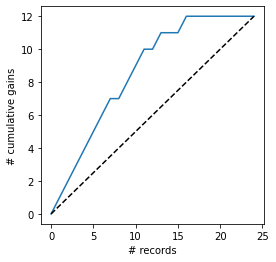

In [7]:
gainsChart(df.actual, figsize=(4,4))
plt.show()

### code for creating a decline lift chart

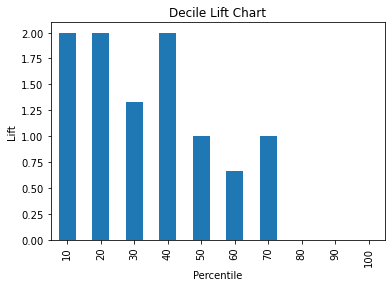

In [8]:
# use liftchart method from utilities
liftChart(df.actual, labelBars=False)
plt.show()